# Initialize functions

In [1]:
import os
import pandas as pd
import torchvision
import torch
from torchvision import transforms

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from PIL import Image



class CustomImageDataset(Dataset):
    def __init__(self, root_dir,csv_file, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = {cls: idx for idx, cls in enumerate(
            ['checazzo', 'peace', 'thumbup', 'ok', 'flat', 'nogesture'])}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path)
        image = image.convert("RGB")


        label = self.annotations.iloc[idx, 1]
        label = self.class_to_idx[label]  # Convert string label to integer
        print(label)
        #sample = {'image': image, 'label': label}

        if self.transform:
            #sample['image'] = self.transform(sample['image'])
            image = self.transform(image)
        
        return image, label

In [2]:
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")


classes = ('checazzo', 'peace', 'thumbup', 'ok', 'flat', 'nogesture')

# Set up transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale conversion to single channel
    transforms.ToTensor(),  # Converts to tensor of shape [1, H, W]
    transforms.Resize((32, 32))  # Resize the image to 32x32
])

# Create dataset
dataset = CustomImageDataset(csv_file='images.csv', root_dir=os.getcwd(), transform=transform)

# Split dataset into 80% train and 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=4, shuffle=False)


Current directory: c:\Visual Computing\Project


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5..1.0000002].


1
2
3
0


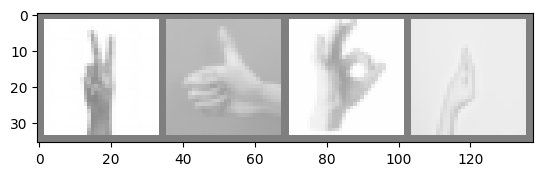

In [3]:
# Function to show images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')  # Specify gray colormap for grayscale
    plt.show()

# Get some random training images
dataset_iter = iter(train_loader)
images, labels = next(dataset_iter)

# Show images
imshow(make_grid(images))  # Display grid of images

## CNN

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

##CNN Architecture

#Generally the CNN output size can be calculated as follows (for an image with same height and width dimensions):
#output_size = (input_size - kernel_size + 2*padding) / stride + 1

#Since we transform each image to grayscale we have 1 input channel.
# Also we use padding, because the most relevant informations lie in the center of the images.csv

#input size of each image: 32x32

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1) 
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) 
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        # Pooling layer for downsampling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout layers for regularization
        self.dropout = nn.Dropout(0.5)


        # Fully connected layers
        self.fc1 = nn.Linear(64*4*4, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 6) #6 output classes 5 gestures and 1 for no gesture

    def forward(self, x):
        x = F.relu(self.conv1(x)) # output size = 32x32
        x = self.pool(F.relu(self.conv2(x))) # output size = 16x16

        x = F.relu(self.conv3(x)) #output size = 16x16
        x = self.pool(F.relu(self.conv4(x))) # output size = 8x8

        x = F.relu(self.conv5(x)) #output size = 8x8
        x = self.pool(F.relu(self.conv6(x))) # output size = 4x4

        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.fc5(x) #no activation function because we use CrossEntropyLoss

        return x

In [5]:
#Hyperparameters
LEARNING_RATE = 0.001
EPOCHS = 30

# Check if the GPU is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#device = torch.device("cuda" if torch.cuda.is_available() else "mps")
#device = torch.device('cpu')
#torch.set_default_device("mps")
print(device)


model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print(model)


cpu
Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=6, bias=True)
)


In [6]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [7]:
from torchsummary import summary

summary(model, (1, 32, 32)) # (channels, height, width of input image)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]              80
            Conv2d-2           [-1, 16, 32, 32]           1,168
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
            Conv2d-5           [-1, 32, 16, 16]           9,248
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
            Conv2d-8             [-1, 64, 8, 8]          36,928
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Linear-10                  [-1, 500]         512,500
          Dropout-11                  [-1, 500]               0
           Linear-12                  [-1, 256]         128,256
          Dropout-13                  [-1, 256]               0
           Linear-14                  [

In [8]:
def train(model, train_loader, optimizer, criterion, n_epochs=None):
    model.train()
    losses = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
        #get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0], data[1]
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            loss_value = loss.item()
            losses.append(loss_value)
            running_loss += loss.item()
            if i % 200 == 199:    # print every 200 mini-batches
                print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    return losses


3
0
2
1
0
1
3
2
0
1
3
2
0
2
1
3
1
3
0
2
1
3
2
0
3
0
1
2
2
3
0
1
1
2
3
0
1
3
0
2
2
0
1
3
0
3
1
2
1
2
0
3
0
2
1
3
2
3
1
0
3
1
0
2
0
2
1
3
1
3
2
0
1
3
2
0
3
2
0
1
1
0
2
3
1
3
0
2
3
0
2
1
1
0
3
2
1
3
0
2
0
2
3
1
1
3
0
2
1
2
0
3
0
2
1
3
0
1
2
3
Finished Training


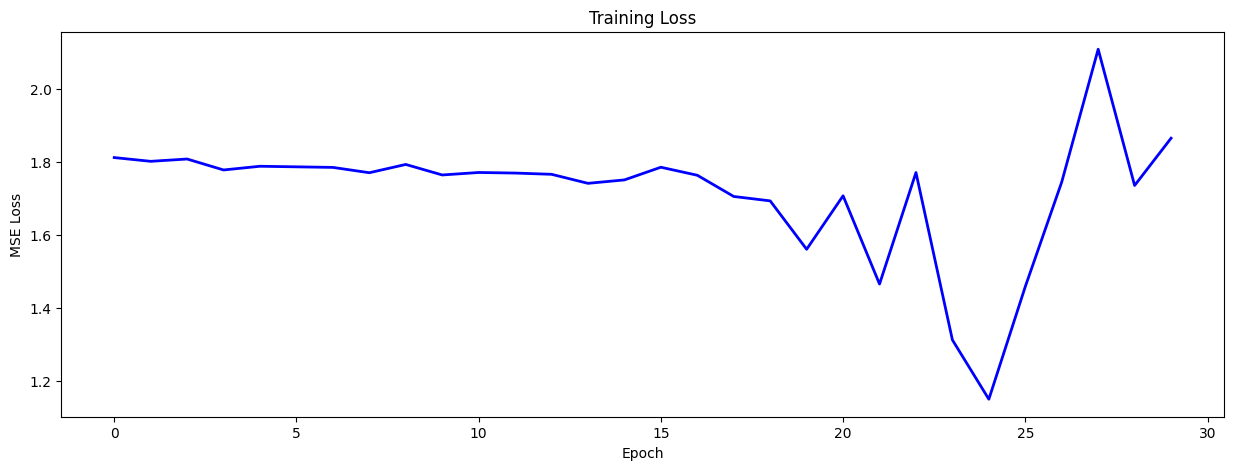

In [9]:
losses = train(model=model, train_loader=train_loader, optimizer=optimizer, criterion=criterion, n_epochs=EPOCHS)

plt.figure(figsize=(15, 5))
plt.plot(losses, lw=2,color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

# Save the trained model
PATH = './model.pth'
torch.save(model.state_dict(), PATH)

C:\Users\gabri\AppData\Local\Temp\ipykernel_2576\3335116341.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))
Clipping input

4


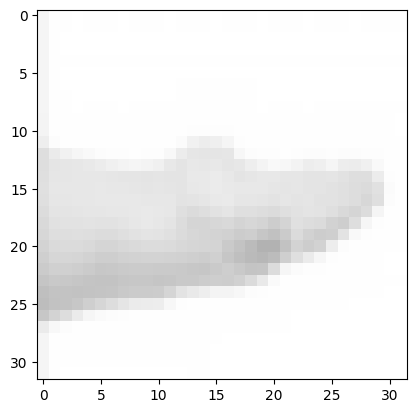

In [10]:
model.load_state_dict(torch.load('model.pth'))

# Check the testset

dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images.cpu()))


In [11]:
# Check the accuracy on the test set
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        print(outputs)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        total += labels.size(0)
        print(total)
        correct += (predicted == labels).sum().item()
        print(correct)
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

4
tensor([[ 0.0898,  0.1684,  0.0916,  0.1530, -0.9156, -0.7850]])
tensor([1])
1
0
Accuracy of the network on the test images: 0 %


In [21]:
# Check the accuracy for each class

class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
        for i in range(len(labels)):
            label = labels[i].item()
            class_correct[label] += c[i].item()
            class_total[label] += 1
            print(class_correct)
            print(class_total)


# Print accuracy for each class
for i in range(len(classes)):
    if class_total[i] > 0:  # Check to avoid division by zero
        accuracy = 100 * class_correct[i] / class_total[i]
        print(f'Accuracy of {classes[i]} : {accuracy:.2f} %')
    else:
        print(f'Accuracy of {classes[i]} : No samples available')

4
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Accuracy of checazzo : No samples available
Accuracy of peace : No samples available
Accuracy of thumbup : No samples available
Accuracy of ok : No samples available
Accuracy of flat : 0.00 %
Accuracy of nogesture : No samples available


## Hand-gesture

In [ ]:
#Hand-gesture recognition v1 / Dataset generation and NN-training

import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from dataaugmentation import augment_dataset
from evaluation import evaluate_model
from CNN import build_model

# Load dataset
def load_dataset(data_dir, image_size=(64, 64)):
    images, labels = [], []
    label_map = {gesture: idx for idx, gesture in enumerate(os.listdir(data_dir))}
    for gesture, idx in label_map.items():
        gesture_dir = os.path.join(data_dir, gesture)
        for img_name in os.listdir(gesture_dir):
            if img_name.endswith('.png'):  # Ensure it's a PNG file
                img_path = os.path.join(gesture_dir, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
                img = cv2.resize(img, image_size) / 255.0  # Resize and normalize
                images.append(img)
                labels.append(idx)
    return np.array(images), np.array(labels), label_map

# Load data
data_dir = "dataset"  # Update with your dataset path
X, y, label_map = load_dataset(data_dir)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)  # Add channel for grayscale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Loaded {len(X)} images, {len(X_train)} for training, {len(X_test)} for testing.")


# Main function
def main():
    # Load dataset
    data_dir = "dataset"  # Update this path with your dataset location
    X, y, label_map = load_dataset(data_dir)
    print(f"Dataset loaded with {len(X)} images.")
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Data augmentation
    X_train_aug, y_train_aug = augment_dataset(X_train, y_train)
    print(f"Dataset augmented: {len(X_train_aug)} training samples.")
    
    # Build and train model
    model = build_model(input_shape=X_train_aug.shape[1:], num_classes=len(label_map))
    model.fit(X_train_aug, y_train_aug, epochs=10, validation_data=(X_test, y_test))
    
    # Evaluate model
    evaluate_model(model, X_test, y_test, label_map)

# Entry point
if __name__ == "__main__":
    main()

## Evaluation

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate and visualize results
def evaluate_model(model, X_test, y_test, label_map):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy: {accuracy}")
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Train CNN with augmented data

# Evaluate Model